Module 03: Feature Engineering
==============================

Domain Knowledge
----------------

Engineered features should start by using your own (or others’)
expertise about the domain.

**Objectives:**

-   Isolate information that may be important
-   Make use of boolean masks to develop new features

Import libraries and load dataset

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# view additional data frame columns
pd.set_option('display.max_columns', 100)

# display plots in the notebook
%matplotlib inline

# load the cleaned dataset
df = pd.read_csv('../dataset/cleaned_df.csv')

Let’s build a feature for 2 beds & 2 baths, which is a popular home
option for investors.

In [69]:
# create a boolean feature
df['two_and_two'] = ((df.beds == 2) & (df.baths == 2)).astype(int)

# determine the percentage of properties that are two_and_two
df.two_and_two.mean() * 100

9.458023379383635

Taking domain knowledge into consideration, we can account for the
housing market recession that occurred between 2010 and 2013. To do so,
we can develop a new feature that indicates whether the property
transaction fell in between the mentioned time period.

In [70]:
# create features based on domain knowledge
df['during_recession'] = df.tx_year.between(left=2010, right=2013).astype(int)

# determine the percentage of transactions that occurred during the recession
df.during_recession.mean() * 100

26.35494155154091

Interaction Features
--------------------

Engineer features based on interaction between two or more features.

**Objectives:**

-   With the use of domain knowledge, build arithmetic features

Let’s build a feature that determines the property age at the time of
the transaction.

In [71]:
# Use arithmetic to construct new features 
df['property_age'] = df.tx_year - df.year_built

# Check for improper data values
df.property_age.describe()

count    1882.000000
mean       24.126461
std        21.153271
min        -8.000000
25%         6.000000
50%        20.000000
75%        38.000000
max       114.000000
Name: property_age, dtype: float64

From our summary statistics, we can see that our minimum property value
is -8. Let’s determine the number properties who also have a negative
age.

In [72]:
# Determine the number of observations that have descrepancies
df.property_age.lt(0).sum()

19

Once again taking domain knowledge into consideration, we can assume
that some properties were purchased before they were constructed. Since
our client is only interested in existing homes, we’ll remove these
exceptions.

In [73]:
# Remove observations that are negative in property age
df = df[df.property_age >= 0]

# review the remaining observations
len(df)

1863

We may find value in building a score system that ranks properties based
on the number of schools nearby and their quality score. To do so, we
can engineer a feature that is a product of both ‘num\_schools’ and
‘median\_school’.

In [74]:
# Create feature for school score
df['school_score'] = df.num_schools * df.median_school
df.school_score.median()

18.0

Sparse Classes
--------------

Reduce the number of sparse classes for categorical features.

**Objectives:**

-   Check for and consolidate similar classes
-   Group sparse classes into a single “Other” class

When consolidating sparse classes, the general rule of thumb is that
each class has at least 50 observations; this is subjective to each data
set and is not an actual guideline.

In [75]:
# review the categorical features in use
df.dtypes[df.dtypes == 'object']

property_type     object
exterior_walls    object
roof              object
dtype: object

Let’s start with the ‘exterior\_walls’ series.

In [76]:
# get value counts for each exterior_walls class
df.exterior_walls.value_counts()

Brick                  682
Siding (Alum/Vinyl)    496
Missing                222
Metal                  120
Combination            106
Wood                    71
Wood Siding             49
Brick veneer            48
Stucco                  23
Concrete                 8
Other                    8
Masonry                  8
Concrete Block           7
Block                    7
Asbestos shingle         6
Wood Shingle             2
Name: exterior_walls, dtype: int64

Alternatively, we can build a seaborn countplot to visualize the
disparity amongst the classes.

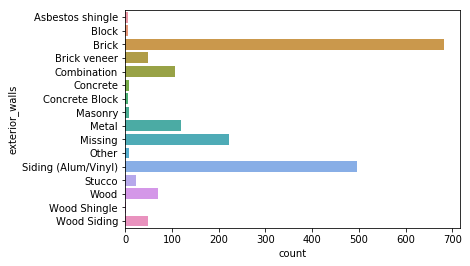

In [77]:
# use a countplot to compare distribution for each feature class
sns.countplot(y=df.exterior_walls.sort_values())

Let’s start consolidating similar classes.

In [78]:
# consolidate similar wood classes
df.exterior_walls.replace(to_replace=['Wood Shingle', 'Wood Siding'], value='Wood', inplace=True) 

Next, we’ll consolidate sparse classes into a single ‘Other’ class.

In [79]:
df.exterior_walls.value_counts()

Brick                  682
Siding (Alum/Vinyl)    496
Missing                222
Wood                   122
Metal                  120
Combination            106
Brick veneer            48
Stucco                  23
Concrete                 8
Other                    8
Masonry                  8
Concrete Block           7
Block                    7
Asbestos shingle         6
Name: exterior_walls, dtype: int64

In [80]:
# group sparse classes into "other"
other_exterior_walls = ['Stucco', 'Concrete Block', 'Masonry', 'Other', 'Asbestos shingle']
df.exterior_walls.replace(to_replace=other_exterior_walls, value='Other', inplace=True)

Let’s look at the classes by count once again.

In [81]:
# unique roof class value counts
df.roof.value_counts()

Composition Shingle     1162
Missing                  352
Asphalt                  136
Shake Shingle             59
Other                     49
Wood Shake/ Shingles      30
Gravel/Rock               30
Roll Composition          12
Slate                      9
Asbestos                   9
Composition                9
Metal                      4
Built-up                   2
Name: roof, dtype: int64

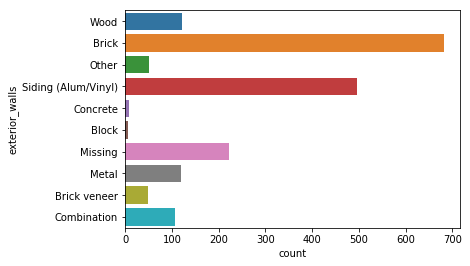

In [82]:
# build a visual seaborn countplot of the exterior walls
sns.countplot(y='exterior_walls', data=df)

We will repeat the same process for the ‘roof’ series.

In [83]:
# get value counts for roof
df.roof.value_counts()

Composition Shingle     1162
Missing                  352
Asphalt                  136
Shake Shingle             59
Other                     49
Wood Shake/ Shingles      30
Gravel/Rock               30
Roll Composition          12
Slate                      9
Asbestos                   9
Composition                9
Metal                      4
Built-up                   2
Name: roof, dtype: int64

In [84]:
# consolidate into the 'Composition Shingle' class
df.roof.replace(['Composition', 'Wood Shake/ Shingles'], 'Composition Shingle', inplace=True)

# list of classes to be replaced by 'Other'
other_roofs = ['Other', 'Gravel/Rock', 'Roll Composition', 'Slate', 'Asbestos', 'Metal', 'Built-up']

# consolidate into the 'Other' class
df.roof.replace(other_roofs, 'Other', inplace=True)

In [85]:
# get value counts for roof
df.roof.value_counts()

Composition Shingle    1201
Missing                 352
Asphalt                 136
Other                   115
Shake Shingle            59
Name: roof, dtype: int64

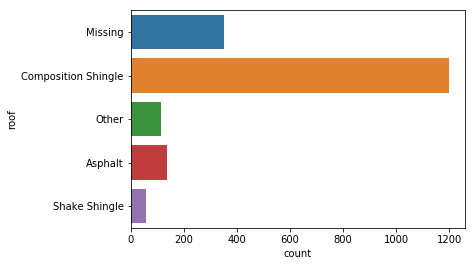

In [86]:
sns.countplot(y='roof', data=df)

Dummy Variables
---------------

In the case of Scikit-Learn, it can’t directly handle categorical
features. Instead, indicator variables must be created for every
categorical class.

For example, our roof class has 5 classes.

In [87]:
# view unique classes for roof
df.roof.unique()

array(['Missing', 'Composition Shingle', 'Other', 'Asphalt',
       'Shake Shingle'], dtype=object)

For any one observation, we will instead need to specify whether the
observation matches any of the classes. In essence, we will need to
create a feature for each class and assign an indicator value.

In [88]:
# convert categorical variables into indicator variables
df = pd.get_dummies(df, columns=['exterior_walls', 'roof', 'property_type'])

Our roof series has now been replaced with five new features.

In [89]:
# display new dummy variables 
df.filter(like='roof').head(5)

,roof_Asphalt,roof_Composition Shingle,roof_Missing,roof_Other,roof_Shake Shingle
0,0,0,1,0,0
1,0,1,0,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0


Remove Unused
-------------

Remove unused or redundant features from the dataset.

**Objectives:**

-   Remove features that don’t make sense to pass into the machine
    learning algorithms.
-   Remove features that are redundant

Since we created the ‘property\_age’ feature, both the ‘tx\_year’ and
‘year\_built’ can be dropped.

In [90]:
df = df.drop(columns=['tx_year', 'year_built'])

Let’s export our updated dataset before moving on.

In [91]:
df.to_csv('../dataset/analytical_base_table.csv', index=None)

Next Module
-----------

[04. Model Training](module04.ipynb)